<a href="https://colab.research.google.com/github/Neermita18/Deep_Learning_Project/blob/main/MFCC_features_RF_Neermita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import shutil
import librosa
import numpy as np
import pandas as pd
from kagglehub import dataset_download


In [ ]:
path = dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to dataset files:", path)

speech_output_path = "/content/ravdess_speech"
os.makedirs(speech_output_path, exist_ok=True)

Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1


In [ ]:
path

'/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1'

In [ ]:

def filter_speech_files(path, output_path):
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith(".wav"):
                parts = file.split("-")

                # Check if it's audio-only (03) and speech (01)
                if parts[0] == "03" and parts[1] == "01":
                    src_path = os.path.join(root, file)
                    dest_path = os.path.join(output_path, file)
                    shutil.copy(src_path, dest_path)
    print(f"Speech audio files saved to: {output_path}")


filter_speech_files(path, speech_output_path)


Speech audio files saved to: /content/ravdess_speech


In [ ]:
# Function to compute Signal-to-Noise Ratio (SNR)
def compute_snr(y):
    signal_power = np.mean(y ** 2)
    noise_power = np.var(y)
    return 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.nan

# Feature extraction function
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    features = {
        "snr": compute_snr(y),
        "mfcc_mean": np.mean(mfccs, axis=1).tolist(),
        "chroma_stft": np.mean(librosa.feature.chroma_stft(y=y, sr=sr)),
        "mel_mean": np.mean(librosa.feature.melspectrogram(y=y, sr=sr)),
        "spectral_contrast": np.mean(librosa.feature.spectral_contrast(y=y, sr=sr)),
        "tonnetz": np.mean(librosa.feature.tonnetz(y=y, sr=sr)) if y.shape[0] > sr else np.nan,
        "spectral_centroid": np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
        "spectral_rolloff": np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),
        "spectral_bandwidth": np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
        "tempo": librosa.beat.tempo(y=y, sr=sr)[0],
        "rms": np.mean(librosa.feature.rms(y=y)),
        "zero_crossing_rate": np.mean(librosa.feature.zero_crossing_rate(y)),
    }

    # Add MFCCs as separate columns
    for i in range(20):
        features[f"mfcc_{i+1}"] = np.mean(mfccs[i, :])

    return features

In [ ]:
# Extract metadata and features
def process_dataset(directory):
    data = []
    for file in os.listdir(directory):
        if file.endswith(".wav"):
            parts = file.split("-")
            emotion = int(parts[2])
            intensity = int(parts[3])
            statement = int(parts[4])
            repetition = int(parts[5])
            actor = int(parts[6].split(".")[0])
            gender = "Female" if actor % 2 == 0 else "Male"

            file_path = os.path.join(directory, file)
            features = extract_features(file_path)

            data.append({
                "file": file,
                "emotion": emotion,
                "intensity": intensity,
                "statement": statement,
                "repetition": repetition,
                "actor": actor,
                "gender": gender,
                **features
            })
    return pd.DataFrame(data)

In [ ]:
df = process_dataset(speech_output_path)

<ipython-input-8-526a4e33ca4e>:21: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  "tempo": librosa.beat.tempo(y=y, sr=sr)[0],


In [ ]:
df.to_csv("ravdess_normal_features.csv", index=False)

In [ ]:
df

,file,emotion,intensity,statement,repetition,actor,gender,snr,mfcc_mean,chroma_stft,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20
0,03-01-06-01-02-01-11.wav,6,1,2,1,11,Male,0.000000e+00,"[-639.836669921875, 69.84195709228516, 6.48526...",0.600782,...,-4.207615,-1.526622,-0.165294,1.208251,-3.237441,0.994905,-2.383292,0.603068,3.380385,-0.920945
1,03-01-08-02-02-01-18.wav,8,2,2,1,18,Female,5.177193e-07,"[-601.0213623046875, 44.49209976196289, -0.472...",0.459541,...,-10.127200,-6.126527,-9.162680,-4.967164,-6.829777,-3.440101,-4.352852,-3.270466,-5.056709,-3.329710
2,03-01-01-01-01-02-01.wav,1,1,1,2,1,Male,0.000000e+00,"[-719.1282958984375, 70.20156860351562, 1.1683...",0.629568,...,-7.648504,-1.477078,3.031821,-2.461868,0.594734,0.978450,-2.836164,0.073816,1.759312,-2.063186
3,03-01-04-01-02-01-22.wav,4,1,2,1,22,Female,0.000000e+00,"[-657.0655517578125, 66.82608795166016, -5.174...",0.491324,...,-6.103499,-1.523775,1.644669,-8.205898,-6.399375,1.155724,-6.472034,-0.133195,-8.596470,-3.782766
4,03-01-01-01-02-02-24.wav,1,1,2,2,24,Female,0.000000e+00,"[-703.79248046875, 58.863800048828125, -6.5915...",0.441171,...,-4.476257,-6.705849,-5.944012,-5.418315,-1.214018,-4.626822,-6.079687,0.602753,-5.309216,-5.097806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,03-01-07-02-01-01-24.wav,7,2,1,1,24,Female,-2.588597e-07,"[-643.1643676757812, 73.10417175292969, -8.130...",0.498962,...,-6.035852,-0.031082,-5.247344,-5.187712,0.906742,-4.394352,-4.094830,1.034234,-2.839900,-3.501388
1436,03-01-05-02-02-01-22.wav,5,2,2,1,22,Female,0.000000e+00,"[-463.7249450683594, 45.929325103759766, -16.5...",0.473655,...,-12.475979,-2.736425,-4.270335,-7.720964,-7.237470,-1.064099,-9.369493,-0.947938,-4.878680,-9.896516
1437,03-01-06-01-02-01-21.wav,6,1,2,1,21,Male,5.177193e-07,"[-605.54248046875, 71.94467163085938, -1.67207...",0.565768,...,-4.488046,0.686382,1.225302,-6.326828,-2.897879,0.912382,-0.569785,0.870771,0.648917,-2.575760
1438,03-01-04-01-02-02-03.wav,4,1,2,2,3,Male,9.318939e-06,"[-645.2114868164062, 92.78839874267578, 0.5813...",0.575326,...,-2.105199,-6.847990,1.344806,2.606021,-5.033450,0.788025,-1.169350,-0.182136,-0.739945,-1.086072


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay


emotion_labels = {
    1: 'Neutral', 2: 'Calm', 3: 'Happy', 4: 'Sad',
    5: 'Angry', 6: 'Fearful', 7: 'Disgust', 8: 'Surprised'
}

file_path = '/content/ravdess_normal_features.csv'
df = pd.read_csv(file_path)


print(df.head())
print(df.info())
print(df.describe())

print(df.isnull().sum())

                       file  emotion  intensity  statement  repetition  actor  \
0  03-01-06-01-02-01-11.wav        6          1          2           1     11   
1  03-01-08-02-02-01-18.wav        8          2          2           1     18   
2  03-01-01-01-01-02-01.wav        1          1          1           2      1   
3  03-01-04-01-02-01-22.wav        4          1          2           1     22   
4  03-01-01-01-02-02-24.wav        1          1          2           2     24   

   gender           snr                                          mfcc_mean  \
0    Male  0.000000e+00  [-639.836669921875, 69.84195709228516, 6.48526...   
1  Female  5.177193e-07  [-601.0213623046875, 44.49209976196289, -0.472...   
2    Male  0.000000e+00  [-719.1282958984375, 70.20156860351562, 1.1683...   
3  Female  0.000000e+00  [-657.0655517578125, 66.82608795166016, -5.174...   
4  Female  0.000000e+00  [-703.79248046875, 58.863800048828125, -6.5915...   

   chroma_stft  ...    mfcc_11   mfcc_12   m

In [ ]:
df["mfcc_mean"]

,mfcc_mean
0,"[-639.836669921875, 69.84195709228516, 6.48526..."
1,"[-601.0213623046875, 44.49209976196289, -0.472..."
2,"[-719.1282958984375, 70.20156860351562, 1.1683..."
3,"[-657.0655517578125, 66.82608795166016, -5.174..."
4,"[-703.79248046875, 58.863800048828125, -6.5915..."
...,...
1435,"[-643.1643676757812, 73.10417175292969, -8.130..."
1436,"[-463.7249450683594, 45.929325103759766, -16.5..."
1437,"[-605.54248046875, 71.94467163085938, -1.67207..."
1438,"[-645.2114868164062, 92.78839874267578, 0.5813..."


In [ ]:
df["mfcc_1"]

,mfcc_1
0,-639.83670
1,-601.02136
2,-719.12830
3,-657.06555
4,-703.79250
...,...
1435,-643.16437
1436,-463.72495
1437,-605.54250
1438,-645.21150


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
X = df.drop(columns=['emotion', "file", "mfcc_mean"])
y = df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
X

,intensity,statement,repetition,actor,gender,snr,chroma_stft,mel_mean,spectral_contrast,tonnetz,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20
0,1,2,1,11,1,0.000000e+00,0.600782,0.019724,15.531321,-0.003297,...,-4.207615,-1.526622,-0.165294,1.208251,-3.237441,0.994905,-2.383292,0.603068,3.380385,-0.920945
1,2,2,1,18,0,5.177193e-07,0.459541,0.026135,14.969766,0.009064,...,-10.127200,-6.126527,-9.162680,-4.967164,-6.829777,-3.440101,-4.352852,-3.270466,-5.056709,-3.329709
2,1,1,2,1,1,0.000000e+00,0.629568,0.003416,13.987218,-0.019908,...,-7.648504,-1.477078,3.031821,-2.461868,0.594734,0.978450,-2.836165,0.073816,1.759312,-2.063186
3,1,2,1,22,0,0.000000e+00,0.491324,0.005726,16.591202,-0.005411,...,-6.103499,-1.523775,1.644669,-8.205898,-6.399375,1.155724,-6.472035,-0.133195,-8.596470,-3.782766
4,1,2,2,24,0,0.000000e+00,0.441171,0.006645,15.542961,-0.017529,...,-4.476257,-6.705849,-5.944012,-5.418315,-1.214018,-4.626823,-6.079687,0.602753,-5.309216,-5.097806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,2,1,1,24,0,-2.588597e-07,0.498962,0.004094,15.124699,-0.004558,...,-6.035852,-0.031082,-5.247344,-5.187712,0.906742,-4.394352,-4.094830,1.034234,-2.839900,-3.501388
1436,2,2,1,22,0,0.000000e+00,0.473655,0.513566,17.651948,-0.009935,...,-12.475979,-2.736425,-4.270335,-7.720964,-7.237470,-1.064099,-9.369493,-0.947938,-4.878680,-9.896516
1437,1,2,1,21,1,5.177193e-07,0.565768,0.023890,15.406441,-0.010664,...,-4.488046,0.686382,1.225302,-6.326828,-2.897879,0.912382,-0.569785,0.870771,0.648917,-2.575760
1438,1,2,2,3,1,9.318939e-06,0.575326,0.005903,16.198481,0.000977,...,-2.105199,-6.847990,1.344806,2.606021,-5.033450,0.788025,-1.169350,-0.182136,-0.739945,-1.086072


In [ ]:
X.shape

(1440, 36)

In [ ]:
y

,emotion
0,6
1,8
2,1
3,4
4,1
...,...
1435,7
1436,5
1437,6
1438,4


In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"\n🔍 {model_name} - Classification Report:\n", classification_report(y_test, y_pred, target_names=list(emotion_labels.values())))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)
        plt.figure(figsize=(10, 8))
        for i, label in enumerate(emotion_labels.values()):
            fpr, tpr, _ = roc_curve(y_test == (i + 1), y_probs[:, i])
            plt.plot(fpr, tpr, label=f'{label} (AUC: {auc(fpr, tpr):.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{model_name} - ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Random Forest Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training Time: 286.03 seconds

🔍 Random Forest - Classification Report:
               precision    recall  f1-score   support

     Neutral       0.78      0.24      0.37        29
        Calm       0.55      0.91      0.69        57
       Happy       0.59      0.60      0.59        57
         Sad       0.58      0.52      0.55        58
       Angry       0.80      0.76      0.78        58
     Fearful       0.62      0.55      0.58        58
     Disgust       0.65      0.56      0.60        57
   Surprised       0.60      0.66      0.63        58

    accuracy                           0.62       432
   macro avg       0.65      0.60      0.60       432
weighted avg       0.64      0.62      0.61       432



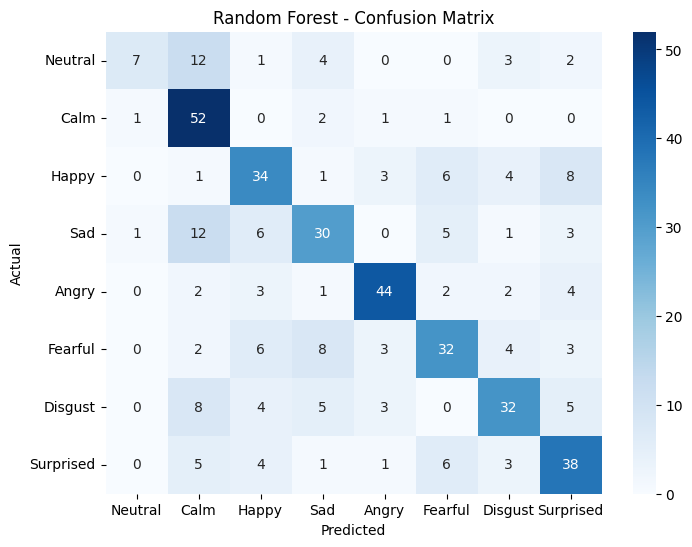

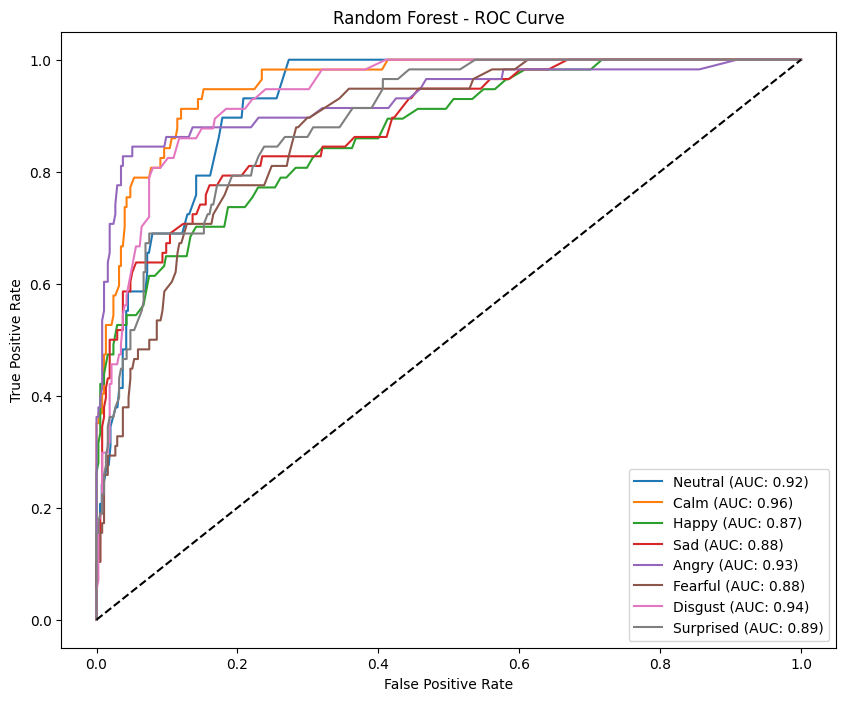

In [ ]:
rf_param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}
rf_model = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

start_time = time.time()
rf_grid_search.fit(X_train, y_train)
end_time = time.time()

print("Random Forest Best Parameters:", rf_grid_search.best_params_)
print(f"Training Time: {end_time - start_time:.2f} seconds")
evaluate_model(rf_grid_search.best_estimator_, X_test, y_test, "Random Forest")

In [ ]:

print("Best Hyperparameters:")
print("Random Forest:", rf_grid_search.best_params_)

Best Hyperparameters:
Random Forest: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
